In [1]:
import numpy as np
import tensorflow as tf

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

First, load the CSV file as a line-by-line text dataset.

In [3]:
filepath = 'housing.csv'
ds = tf.data.TextLineDataset(filepath)  # the most common way of reading a csv file in TF Data API
for line in ds.take(5):   # show the first 5 rows of the CSV file
    print(line.numpy())   # display each line as a string (as opposed to a tf.Tensor)

b' 0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00'
b' 0.02731   0.00   7.070  0  0.4690  6.4210  78.90  4.9671   2  242.0  17.80 396.90   9.14  21.60'
b' 0.02729   0.00   7.070  0  0.4690  7.1850  61.10  4.9671   2  242.0  17.80 392.83   4.03  34.70'
b' 0.03237   0.00   2.180  0  0.4580  6.9980  45.80  6.0622   3  222.0  18.70 394.63   2.94  33.40'
b' 0.06905   0.00   2.180  0  0.4580  7.1470  54.20  6.0622   3  222.0  18.70 396.90   5.33  36.20'


Create a CSV parser.

In [4]:
n_columns = 14

# @tf.function
def parse_csv(line):
    '''
    function to parse each line of the CSV file
    '''
    record_defaults=[np.nan]*n_columns  # when there's a missing cell, mark it as NaN (Not a Number)

    # The BH dataset does not follow the usual comma-separated format.
    # Instead it has multiple whitespaces to separate columns. 
    line = tf.strings.strip(line)   # strip white spaces at the front and the back of the string
    line = tf.strings.regex_replace(line, ' +', ',')   # replace multiple spaces to a single comma

    fields = tf.io.decode_csv(line, record_defaults=record_defaults) # parse the columns (fields)
    x = tf.stack(fields[:-1])   # the first 13 columns are the independent variables
    y = tf.stack(fields[-1:])   # the last column is the dependent variable
    return x, y

# test if the parser works
parse_csv(b' 0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00')

(<tf.Tensor: shape=(13,), dtype=float32, numpy=
 array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
        6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
        4.980e+00], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([24.], dtype=float32)>)

Parse each row of the CSV file into a feature vector (x) and a dependent variable (y).

In [5]:
ds_parsed = ds.map(parse_csv)
for x, y in ds_parsed.take(3):   # show the first 3 entries
    print('x =', x)
    print('y =', y)
    print('')

x = tf.Tensor(
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00], shape=(13,), dtype=float32)
y = tf.Tensor([24.], shape=(1,), dtype=float32)

x = tf.Tensor(
[2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
 7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
 9.1400e+00], shape=(13,), dtype=float32)
y = tf.Tensor([21.6], shape=(1,), dtype=float32)

x = tf.Tensor(
[2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 7.1850e+00
 6.1100e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9283e+02
 4.0300e+00], shape=(13,), dtype=float32)
y = tf.Tensor([34.7], shape=(1,), dtype=float32)



Compute the mean and the standarad deviation

In [6]:
feature_mean = tf.zeros((13,))
cnt = 0
for x, _ in ds_parsed:
    feature_mean += x
    cnt += 1
feature_mean /= cnt

print(feature_mean)

feature_std = tf.zeros((13,))
for x, y in ds_parsed:
    feature_std += (x - feature_mean)**2
feature_std /= cnt
feature_std = tf.math.sqrt(feature_std)

print(feature_std)

tf.Tensor(
[3.6135232e+00 1.1363636e+01 1.1136797e+01 6.9169961e-02 5.5469555e-01
 6.2846355e+00 6.8574921e+01 3.7950428e+00 9.5494070e+00 4.0823715e+02
 1.8455584e+01 3.5667456e+02 1.2653064e+01], shape=(13,), dtype=float32)
tf.Tensor(
[8.5930414e+00 2.3299332e+01 6.8535724e+00 2.5374201e-01 1.1576311e-01
 7.0192248e-01 2.8121040e+01 2.1036289e+00 8.6986599e+00 1.6837056e+02
 2.1628053e+00 9.1204582e+01 7.1340027e+00], shape=(13,), dtype=float32)


Standaradize the data

In [7]:
@tf.function
def standardize(x, y):
    return (x - feature_mean) / feature_std, y

ds_std = ds_parsed.map(standardize)
for x, y in ds_std.take(3):
    print('x =', x)
    print('y =', y)
    print('')

x = tf.Tensor(
[-0.4197819   0.28483066 -1.2879119  -0.27259958 -0.14422175  0.41367
 -0.12001418  0.14021361 -0.98284185 -0.6666079  -1.4590234   0.44104618
 -1.0755622 ], shape=(13,), dtype=float32)
y = tf.Tensor([24.], shape=(1,), dtype=float32)

x = tf.Tensor(
[-0.41733924 -0.48772368 -0.5933835  -0.27259958 -0.7402663   0.19427282
  0.36716568  0.5571598  -0.8678816  -0.98732907 -0.3031176   0.44104618
 -0.49243933], shape=(13,), dtype=float32)
y = tf.Tensor([21.6], shape=(1,), dtype=float32)

x = tf.Tensor(
[-0.41734153 -0.48772368 -0.5933835  -0.27259958 -0.7402663   1.282712
 -0.26581243  0.5571598  -0.8678816  -0.98732907 -0.3031176   0.39642116
 -1.2087274 ], shape=(13,), dtype=float32)
y = tf.Tensor([34.7], shape=(1,), dtype=float32)



Split the dataset into train, val, test

In [8]:
ds_shuffled = ds_std.shuffle(1024)
# ds_shuffled = ds_std.shuffle(1024, seed = 42, reshuffle_each_iteration = False)
ds_test = ds_shuffled.take(100)  # the first 100 samples will be set aside for test and validation
ds_train = ds_shuffled.skip(100) # the remainder will be used for training

ds_val = ds_test.take(50)    # the first 50 among the set-aside samples will be used for validation
ds_test = ds_test.skip(50)   # the remainder of the set-aside samples willb e used for testing

(Bonus) Augment the dataset by adding noise. Note that with this simple data augmentation trick, we can achieve a smaller MSE than the case without it.

In [9]:
@tf.function
def augment(x, y):
  return x + tf.random.normal((13,), 0, 0.0005), y

ds_train = ds_train.repeat(10).map(augment)  # augment the dataset by 10x
for x, y in ds_train.take(3):
    print('x =', x)
    print('y =', y)
    print('')

x = tf.Tensor(
[-0.38596657 -0.48746437 -0.72040313 -0.2731876  -0.43781343  1.9960691
 -1.8346875  -0.20042296 -0.17801711 -0.6010033  -0.4878338   0.22889358
 -1.2237452 ], shape=(13,), dtype=float32)
y = tf.Tensor([46.7], shape=(1,), dtype=float32)

x = tf.Tensor(
[-0.4159978  -0.48748416 -0.8678576  -0.27205208 -0.3428577   0.03522629
 -1.0690029   1.2668046  -0.5226832  -1.0939199   0.8056515   0.35829353
 -0.82781696], shape=(13,), dtype=float32)
y = tf.Tensor([20.7], shape=(1,), dtype=float32)

x = tf.Tensor(
[-0.36704725 -0.48732916 -0.7193502  -0.27239266 -0.4372101   1.6063106
  0.29641312 -0.05880021 -0.17754577 -0.6007919  -0.4872447   0.21344613
 -1.0369585 ], shape=(13,), dtype=float32)
y = tf.Tensor([31.7], shape=(1,), dtype=float32)



Batch and prefetch

In [10]:
ds_train = ds_train.batch(32).prefetch(1)
ds_val = ds_val.batch(50)   # a single batch containing the entire set
ds_test = ds_test.batch(50) # a single batch containing the entire set

Build, compile, and train the model

In [11]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(13,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(18, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [12]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = tf.keras.metrics.RootMeanSquaredError(name='rmse', dtype=None))

history = model.fit(ds_train, epochs=300, validation_data=ds_val)

Epoch 1/300
127/127 [==============================] - 5s 26ms/step - loss: 279.8901 - rmse: 16.7299 - val_loss: 32.2327 - val_rmse: 5.6774
Epoch 2/300
127/127 [==============================] - 2s 12ms/step - loss: 19.0065 - rmse: 4.3596 - val_loss: 9.4823 - val_rmse: 3.0793
Epoch 3/300
127/127 [==============================] - 2s 12ms/step - loss: 13.0768 - rmse: 3.6162 - val_loss: 19.7366 - val_rmse: 4.4426
Epoch 4/300
127/127 [==============================] - 2s 12ms/step - loss: 11.1982 - rmse: 3.3464 - val_loss: 12.7337 - val_rmse: 3.5684
Epoch 5/300
127/127 [==============================] - 2s 11ms/step - loss: 10.0171 - rmse: 3.1650 - val_loss: 19.6944 - val_rmse: 4.4378
Epoch 6/300
127/127 [==============================] - 1s 8ms/step - loss: 9.1867 - rmse: 3.0310 - val_loss: 8.2994 - val_rmse: 2.8809
Epoch 7/300
127/127 [==============================] - 1s 7ms/step - loss: 8.4294 - rmse: 2.9034 - val_loss: 6.1840 - val_rmse: 2.4868
Epoch 8/300
127/127 [==================

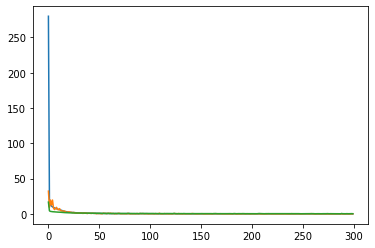

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['rmse'])

In [14]:
model.evaluate(ds_test)

1/1 [==============================] - 0s 121ms/step - loss: 0.0461 - rmse: 0.2148


[0.0461432971060276, 0.21480990946292877]